# This is an interactive file for transforming the raw t-cell/dcell dataset into compressed files.

## The issue comes from high RAM usage both locally and in Google Colab.

## Input format:
- A folder containing images 
- Each image has a counterpart: for each "filename" (letter - digit), there is a red image, and a green image
- red image = tcell
- green image = dendritic cell
- we need both the separated images (B&W) and the combined images (RGB)
- Each image is 2048x2048 8MB TIFF image

## Steps
1. Pass a 192x192 sliding window over the images. 
2. Store the filenames
3. Take each of the reduced images, and combine them to create RGB images (red channel = tcell, green channel = dcell)
4. Calculate the intersection over union overlap for each image and store it in a file.

## Output:
**DATA_full.npz**
- x: raw images 
- y: raw filename names (there will be duplicates)   

**DATA_overlaps.npz**
- y_overlaps : overlap value for RGB image 

### The reason I am not combining tcell+dcell in a RGB dataset is because doing that resulted in a 13Gig dataset (3 times as big) that I cannot send to Google Drive, which I use to train models with a GPU through Colab.
### Hence the original, unmodified images need to be kept to be processed in-notebook. 

## Step 1: pass a sliding window over the images

In [1]:
from dataset_helpers import read_folder_filenames, is_dmso
from dataset_helpers import sliding_window

from skimage.io import imread
import numpy as np

In [3]:
def compress_images(out, filenames, size):
    """
    returns:
    a npz file of:
     - image arrays in shape (size, size, 1)
     - filenames (unmodified)
    
    @parameters:
    out = name of the outputted compressed file
    filenames = all filenames of files to compress
    size = size of output images 
    
    
    @assumptions:
    * validity of filenames has been checked
    """
    
    compressed = []
    fn = []
    
    for file in filenames:
        img = imread(file)
        windows = sliding_window(img, size)
        img = None
        for img in windows:
            compressed.append(img)
            fn.append(file)
            img = None
        windows = None
    
    compressed = np.array(compressed)
    fn = np.array(fn)
    np.savez(out, x=compressed, y=fn)
    
    print("All files compressed into %s" % out)

### Loading filenames

In [ ]:
#filenames = sorted(read_folder_filenames(your_folder_here))

In [4]:
folder = '/Volumes/TARDIS/'

In [5]:
CK19_files = sorted(read_folder_filenames(folder+"CK19"))
CK21_files = sorted(read_folder_filenames(folder+"CK21"))
CK22_files = sorted(read_folder_filenames(folder+"CK22_half"))

In [ ]:
all_files = sorted([CK19_files, CK21_files, CK22_files])

In [ ]:
DMSO_files = []
for file in all_files:
    if is_dmso(file):
        DMSO_files.append(file)

### Take into consideration before running:
* this will take A LOT of memory
* laptop struggles on 8MB of ram


In [ ]:
#compress_images("your_output", your_files, your_size)

In [ ]:
compress_images("/Volumes/TARDIS/CK19_full.npz", CK19_files, 192)

In [ ]:
compress_images("/Volumes/TARDIS/DMSO_full.npz", DMSO_files, 192)

In [6]:
compress_images("/Volumes/TARDIS/CK22_half.npz", CK22_files, 192)

All files compressed into /Volumes/TARDIS/CK22_half.npz


## Step 2: Capture overlap metrics from combined images.

In [ ]:
#npzfile = np.load("your_npz_file")

In [2]:
npzfile = np.load("/Volumes/TARDIS/CK22_half.npz")

In [3]:
x = npzfile['x']
filenames = npzfile['y']

In [5]:
from dataset_helpers import combine_images
from segmentation import get_mask, iou

In [6]:
# combined images, associated label
x_combined, y_combined = combine_images(x, filenames, mask=False)

Images preprocessed. Size of dataset: 19150


In [7]:
def get_overlaps(x, y):
    overlaps = np.ndarray(shape=(len(x),), dtype=np.float32) # overlap values - combined

    # initialise index values
    i = 0

    print("Looping through images...")
    while i < len(x):
        if y[i] == 3:
            # image is faulty
            overlaps[i] = 0
        else:
            overlaps[i] = iou(get_mask(x[i, ..., 1]), get_mask(x[i, ..., 0]))

        i += 1
    return overlaps

In [8]:
y_overlaps = get_overlaps(x_combined, y_combined)

Looping through images...


In [17]:
from evaluation_helpers import show_image

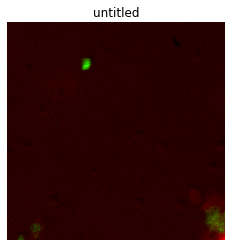

In [18]:
show_image(x_combined[909])

In [20]:
y_overlaps.m

0.3846154

In [ ]:
#out = "your_out_file"

In [15]:
out = "/Volumes/TARDIS/CK22_half_overlaps.npz"

In [16]:
np.savez(out, overlaps=y_overlaps)